### Setup

In [1]:
import requests
from decimal import Decimal
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from web3 import Web3
from web3.beacon import Beacon
#If you need to install any tools, uncomment the line below and replace with desired
from datetime import datetime, date



In [2]:
# !pip3 install BeautifulSoup3

In [3]:
#define some fancy functions
def get_eth_price():
    url = "https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd"
    response = requests.get(url)
    data = response.json()
    eth_price = data['ethereum']['usd']
    print('1 ETH = $',eth_price)
    return int(eth_price)
eth_price=get_eth_price()

def format_with_commas(x, _):
    return '${:,.0f}'.format(x)

def format_eth(x, _):
    return '- {:,.2f} ETH'.format(x)

1 ETH = $ 1780.66


### Define the Validator IDs to extract

In [12]:
validator_ids = [81070, 83909,83908,83923,83932]

## BeautifulSoup & beaconcha.in 

In [13]:
pd.set_option('display.width', 150)
pd.set_option('display.precision', 5)
BASE_URL = "https://beaconcha.in/validator/"

def get_validator_rewards(validator_id): #function to get data from the beaconcha.in website on a single validator ID
    url = BASE_URL + str(validator_id)
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to get data for validator ID {validator_id}")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Locate the "Income 1d | 7d | 31d" section
    income_section_element = soup.find(string=re.compile(r"Income 1d \| 7d \| 31d", re.IGNORECASE))
    val_1d, val_7d, val_31d = 0, 0, 0
    if income_section_element:
        income_values_element = income_section_element.find_next('td')
        # Combined regular expression for both CL and EL values
        pattern = r'CL:\s*\+\s*(?P<cl1d>[\d\.]+)\s*ETH\s*\|\s*\+\s*(?P<cl7d>[\d\.]+)\s*ETH\s*\|\s*\+\s*(?P<cl31d>[\d\.]+)\s*ETH|EL:\s*\+\s*(?P<el1d>[\d\.]+)\s*ETH\s*\|\s*\+\s*(?P<el7d>[\d\.]+)\s*ETH\s*\|\s*\+\s*(?P<el31d>[\d\.]+)\s*ETH'
        for match in re.finditer(pattern, str(income_values_element)):
            val_1d += float(match.group('cl1d') or match.group('el1d') or 0)
            val_7d += float(match.group('cl7d') or match.group('el7d') or 0)
            val_31d += float(match.group('cl31d') or match.group('el31d') or 0)
    
    # Locate the "APR 7d | 31d | 365d" section
    apr_section_element = soup.find(string=re.compile(r"APR 7d \| 31d \| 365d", re.IGNORECASE))
    apr_7d, apr_31d, apr_365d = 0, 0, 0
    if apr_section_element:
        apr_values_element = apr_section_element.find_next('td')
        # Regular expression to capture CL and EL APR values, using case-insensitive matching
        apr_pattern = r'CL:\s*(?P<cl7d>[\d\.]+)%\s*\|\s*(?P<cl31d>[\d\.]+)%\s*\|\s*(?P<cl365d>[\d\.]+)%|EL:\s*(?P<el7d>[\d\.]+)%\s*\|\s*(?P<el31d>[\d\.]+)%\s*\|\s*(?P<el365d>[\d\.]+)%'
        apr_pattern = re.compile(apr_pattern, re.IGNORECASE)  # Create a case-insensitive regex object
        for match in apr_pattern.finditer(str(apr_values_element)):
            apr_7d += float(match.group('cl7d') or 0) + float(match.group('el7d') or 0)
            apr_31d += float(match.group('cl31d') or 0) + float(match.group('el31d') or 0)
            apr_365d += float(match.group('cl365d') or 0) + float(match.group('el365d') or 0)
    
    # Extract CL and EL data from the "Total Rewards" section
    cl_val, el_val = 0, 0
    total_rewards_section = soup.find('th', string=re.compile(r"Total\s+Rewards", re.IGNORECASE))
    if total_rewards_section:
        cl_match = re.search(r'CL:\s*\+([\d\.]+)', str(total_rewards_section.find_next_siblings()))
        el_match = re.search(r'EL:\s*\+([\d\.]+)', str(total_rewards_section.find_next_siblings()))
        cl_val = float(cl_match.group(1)) if cl_match else 0
        el_val = float(el_match.group(1)) if el_match else 0
    return validator_id, cl_val, el_val, cl_val + el_val, val_1d, val_7d, val_31d, apr_7d, apr_31d, apr_365d

### Validator Earnings dataframe ($ETH)

In [14]:
df = pd.DataFrame(columns=['Validator_ID', 'Total Base Pay (ETH)', 'Total Tips (ETH)', 'Total Income (ETH)', '1d Income (ETH)','7d Income (ETH)','31d Income (ETH)', 'APR 7d (%)', 'APR 31d (%)', 'ROI (%)'])

# Modify the append part to include APR values in the dataframe
for validator_id in validator_ids:
    rewards = get_validator_rewards(validator_id)
    if rewards:
        df = df.append({
            'Validator_ID': rewards[0],'Total Base Pay (ETH)': rewards[1], 'Total Tips (ETH)': rewards[2], 'Total Income (ETH)': rewards[3],'1d Income (ETH)': rewards[4],'7d Income (ETH)': rewards[5],'31d Income (ETH)': rewards[6],'APR 7d (%)': rewards[7],'APR 31d (%)': rewards[8],'ROI (%)': rewards[9]}, ignore_index=True)
df['Validator_ID'] = df['Validator_ID'].astype(int)
df = df.sort_values(by='Validator_ID')
df['Validator_Number'] = range(1, len(df) + 1)

print('Validator info in ETH (Ether)')
display(df)

Validator info in ETH (Ether)


,Validator_ID,Total Base Pay (ETH),Total Tips (ETH),Total Income (ETH),1d Income (ETH),7d Income (ETH),31d Income (ETH),APR 7d (%),APR 31d (%),ROI (%),Validator_Number
0,81070,4.26451,0.25685,4.52136,0.00231,0.01609,0.06378,2.62,2.35,14.12,1
2,83908,4.32912,0.18300,4.51212,0.00231,0.01610,0.07174,2.62,2.64,14.09,2
1,83909,4.53442,0.76362,5.29804,0.00231,0.01613,0.13859,2.63,5.10,16.55,3
3,83923,4.35741,0.17123,4.52864,0.00230,0.01614,0.07184,2.63,2.64,14.15,4
4,83932,4.54098,0.64320,5.18418,0.00231,0.01610,0.07178,2.62,2.64,16.19,5


### Validator Earnings dataframe ($USD)

In [15]:
# this seciton will covert any column with (ETH) in the name to have each row be USD $ and then remove ETH from column name
df_dollar=df.copy()
col=['1d Income (ETH)','7d Income (ETH)','31d Income (ETH)']
for col in df_dollar.columns:
    if '(ETH)' in col:
        df_dollar[col] = df_dollar[col].apply(lambda x: f"${x*eth_price:,.2f}")

df_dollar.columns = [col.replace(' (ETH)', '') for col in df_dollar.columns]
print('Validator info in USD ($)')
display(df_dollar)

Validator info in USD ($)


,Validator_ID,Total Base Pay,Total Tips,Total Income,1d Income,7d Income,31d Income,APR 7d (%),APR 31d (%),ROI (%),Validator_Number
0,81070,"$7,590.83",$457.19,"$8,048.02",$4.11,$28.64,$113.53,2.62,2.35,14.12,1
2,83908,"$7,705.83",$325.74,"$8,031.57",$4.11,$28.66,$127.70,2.62,2.64,14.09,2
1,83909,"$8,071.27","$1,359.24","$9,430.51",$4.11,$28.71,$246.69,2.63,5.10,16.55,3
3,83923,"$7,756.19",$304.79,"$8,060.98",$4.09,$28.73,$127.88,2.63,2.64,14.15,4
4,83932,"$8,082.94","$1,144.90","$9,227.84",$4.11,$28.66,$127.77,2.62,2.64,16.19,5


### Beaconcha.in API for validator Status/Age/pubkey

In [16]:
def BeaconAPI(validator_id):
    base_url = "https://beaconcha.in/api/v1/validator/"
    response = requests.get(base_url + str(validator_id))
    main_data = response.json()

    data = main_data.get('data', {})  # Extract the nested data dictionary
    activation_epoch = data.get('activationepoch', 0)
    Validator_ID = data.get('validatorindex', 0)
    status = data.get('status', '')
    pubkey = data.get('pubkey', '')

    base_url2 = "https://beaconcha.in/api/v1/epoch/"
    response2 = requests.get(base_url2 + str(activation_epoch))
    side_data = response2.json()
    epoch_date = side_data['data'].get('ts', 0)
    epoch_date_obj = datetime.strptime(epoch_date, "%Y-%m-%dT%H:%M:%SZ").date()

    # Calculate the difference
    days_difference = (date.today() - epoch_date_obj).days

    return Validator_ID, status, pubkey, days_difference



In [17]:
result_df = pd.DataFrame(columns=['Validator_ID', 'Status', 'Pubkey', 'Days Old'])  # Initialize DataFrame outside of the loop

for ID in df['Validator_ID']:
    validator_id, status, pubkey, days_difference = BeaconAPI(ID)
    result_df = result_df.append({'Validator_ID': validator_id, 'Status': status, 'Pubkey': pubkey, 'Days Old': days_difference}, ignore_index=True)

# print(result_df)
df = pd.merge(df, result_df, on='Validator_ID', how='left')
display(df)

,Validator_ID,Total Base Pay (ETH),Total Tips (ETH),Total Income (ETH),1d Income (ETH),7d Income (ETH),31d Income (ETH),APR 7d (%),APR 31d (%),ROI (%),Validator_Number,Status,Pubkey,Days Old
0,81070,4.26451,0.25685,4.52136,0.00231,0.01609,0.06378,2.62,2.35,14.12,1,active_online,0xa14fbb4bd79bc63145a0647e2ecdb1f7328be89012e1...,995
1,83908,4.32912,0.18300,4.51212,0.00231,0.01610,0.07174,2.62,2.64,14.09,2,active_online,0x8603d7b25ea344e3e7dea71606e3dc1cad1411e9f72b...,992
2,83909,4.53442,0.76362,5.29804,0.00231,0.01613,0.13859,2.63,5.10,16.55,3,active_online,0x904dca9e7218e03a8721956fa9add84b88d1f4f03e8f...,992
3,83923,4.35741,0.17123,4.52864,0.00230,0.01614,0.07184,2.63,2.64,14.15,4,active_online,0xb62c0d8ebfbee4dc863122e8ae0206dc6098c1e5b78a...,992
4,83932,4.54098,0.64320,5.18418,0.00231,0.01610,0.07178,2.62,2.64,16.19,5,active_online,0x83a3ba5e89ddfc1555c0fc26526aea7a5555262b1afd...,992


### Total Rewards Per Validator - Plot

9631


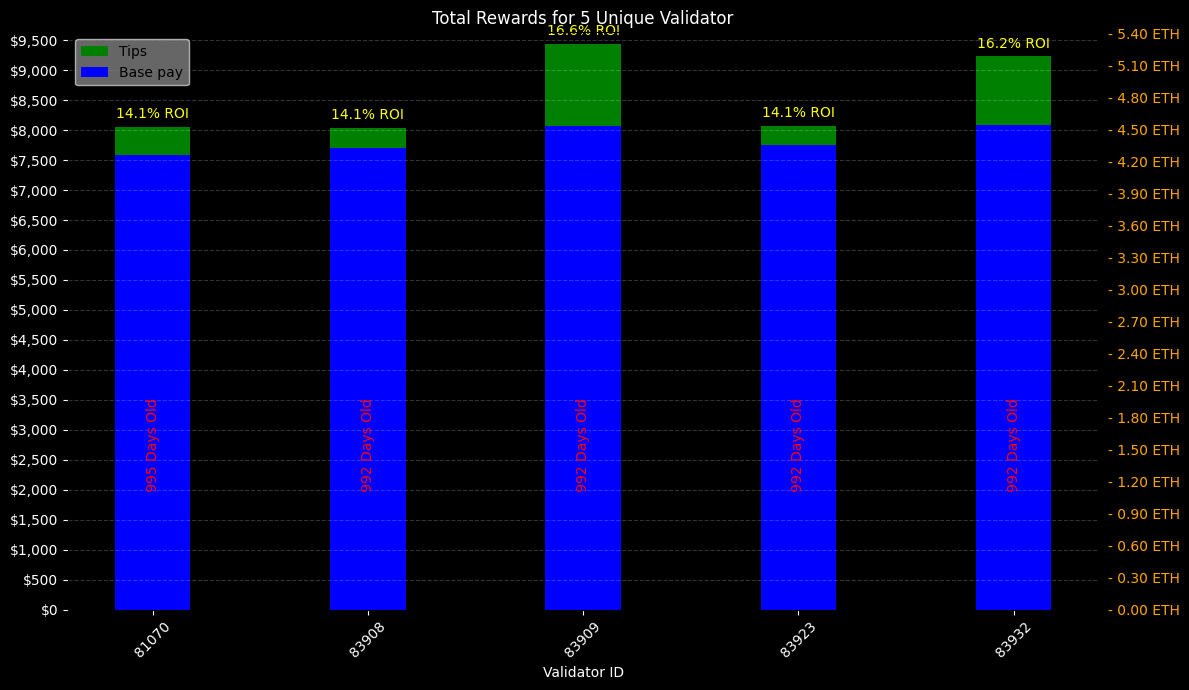

In [18]:
ax=[];ax2=[];fig=[]
fig, ax = plt.subplots(figsize=(12, 7))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

indices = np.arange(len(df['Validator_ID']))
bar_width = 0.35

# Convert earnings to dollars
base_pay_dollars = df['Total Base Pay (ETH)'] * eth_price
tips_dollars = df['Total Tips (ETH)'] * eth_price
max_value = max(base_pay_dollars + tips_dollars)
rounded_max = round(max_value)+200
print(rounded_max)
# Bars
bars1 = ax.bar(indices, base_pay_dollars, bar_width, label='Base pay', color='blue')
bars2 = ax.bar(indices, tips_dollars, bar_width, label='Tips', color='green', bottom=base_pay_dollars)

# Styling
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.title.set_color('white')

# y-axis (in $)
ax.set_ylim(0, rounded_max)
ax.yaxis.set_major_formatter(FuncFormatter(format_with_commas))
ax.yaxis.set_major_locator(MaxNLocator(nbins=20))  # Adjust the number of y-axis ticks
ax.yaxis.grid(True, linestyle='--', which='major', color='white', alpha=0.2)

# Secondary y-axis (in ETH)
ax2 = ax.twinx() 
ax2.set_ylim(0, rounded_max/eth_price)  
ax2.tick_params(axis='y', labelcolor='orange')
ax2.yaxis.set_major_formatter(FuncFormatter(format_eth))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=20))  # Adjust the number of y-axis ticks for ETH

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Validator ID')
ax.set_title('Validator Rewards by Base pay and Tips')
ax.set_title(f'Total Rewards for {len(tips_dollars)} Unique Validator')
ax.set_xticks(indices)
validator_ids = df['Validator_ID']
ax.set_xticklabels(validator_ids, rotation=45)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], facecolor='grey')
for i in range(len(df)):
    height = bars1[i].get_height() + bars2[i].get_height()  # sum of base_pay and tips
    ax.text(bars1[i].get_x() + bars1[i].get_width()/2., height + 100, 
            f"{df['ROI (%)'].iloc[i]:.1f}% ROI", ha='center', va='bottom', color='yellow')
for i, validator_id in enumerate(validator_ids):
    #Adjust spacing for days old
    ax.text(i, 0, f"                           {df['Days Old'].iloc[i]:,.0f} Days Old", ha='center', va='bottom', rotation=90, color='red')

plt.tight_layout()
plt.show()


### Total Validator Balance with Rewards

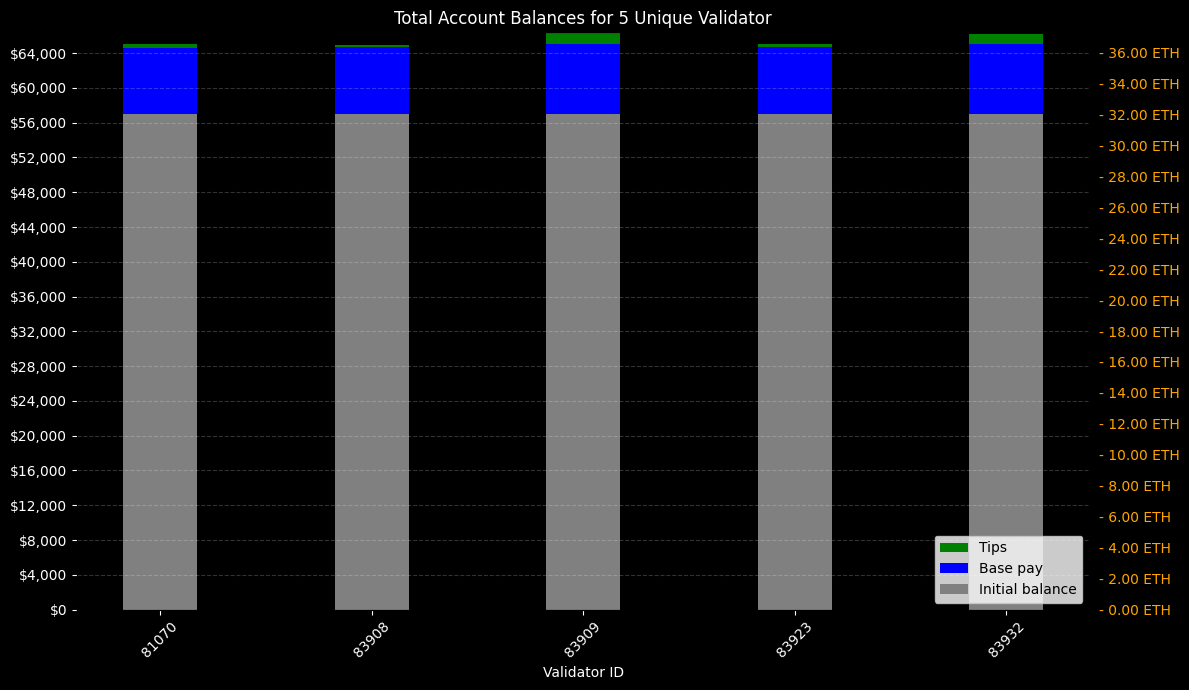

In [19]:

#Assume the Validator is still online with a balance of 32 ETH to start with (:
df['Starting balance (ETH)'] = 32
#clear plot from last
ax=[];ax2=[];fig=[]

# Convert earnings to dollars
starting_balance_dollars = df['Starting balance (ETH)'] * eth_price
base_pay_dollars = df['Total Base Pay (ETH)'] * eth_price
tips_dollars = df['Total Tips (ETH)'] * eth_price
max_value = max(starting_balance_dollars + base_pay_dollars + tips_dollars)
rounded_max = round(max_value)
fig, ax = plt.subplots(figsize=(12, 7))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

indices = np.arange(len(df['Validator_ID']))
bar_width = 0.35

# 2. Bars for Starting balance, Base pay, and Tips
bars0 = ax.bar(indices, starting_balance_dollars, bar_width, label='Initial balance', color='grey')
bars1 = ax.bar(indices, base_pay_dollars, bar_width, label='Base pay', color='blue', bottom=starting_balance_dollars)
bars2 = ax.bar(indices, tips_dollars, bar_width, label='Tips', color='green', bottom=starting_balance_dollars+base_pay_dollars)

# Styling
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.title.set_color('white')

# y-axis (in $)
ax.set_ylim(0, rounded_max)
ax.yaxis.set_major_formatter(FuncFormatter(format_with_commas))
ax.yaxis.set_major_locator(MaxNLocator(nbins=20))  # Adjust the number of y-axis ticks
ax.yaxis.grid(True, linestyle='--', which='major', color='white', alpha=0.2)


# Secondary y-axis (in ETH)
ax2 = ax.twinx()
ax2.set_ylim(0, rounded_max/eth_price)
ax2.tick_params(axis='y', labelcolor='orange')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"- {x:,.2f} ETH"))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=20))

# Validator listing
ax.set_xlabel('Validator ID')
ax.set_title(f'Total Account Balances for {len(tips_dollars)} Unique Validator')
ax.set_xticks(indices)
validator_ids = df['Validator_ID']
ax.set_xticklabels(validator_ids, rotation=45)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[::-1], labels[::-1], facecolor='white', loc='lower right')
plt.tight_layout()
plt.show()